In [1]:
import os
import pandas as pd
import numpy as np
from quantities import ns, s
from neo.core import SpikeTrain
from elephant.statistics import isi, cv, mean_firing_rate
import matplotlib.pyplot as plt
plt.style.use('ggplot')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\ProgramData\Anaconda3\lib\site-packages\elephant\spade.py:82: UserWarning: fim.so not found in elephant/spade_src folder,you are using the python implementation of fast fca
  'you are using the python implementation of fast fca')


In [93]:
font = {'fontname':'Calibri'}

def load_data(recording, data_dir, verbose):
    if verbose:
        print('Loading data:\t{}'.format(recording))
    path = ''.join([os.path.join(data_dir, recording, recording), '.csv'])
    return pd.read_csv(path)


def manipulate_df(df):
    df['spike'] = 1
    df['time'] = pd.to_timedelta(df['time'], unit='s')
    return df


def create_time_series(df):
    df = df.pivot_table(index='time',
                        columns='spike_cluster',
                        values='spike',
                        aggfunc='count')
    return df


def get_condition_times(df, experiment):
    if experiment == 'DREADD':
        max_time = df[df['condition'] == 'CNO']['time'].iloc[-1].total_seconds()
        max_time = list(zip(['CNO'], [max_time]))
        n_conditions = 1
    elif experiment == 'CIT':
        max_time_cit = df[df['condition'] == 'CIT']['time'].iloc[-1].total_seconds()
        if 'WAY' in df['condition'].values:
            max_time_way = df[df['condition'] == 'WAY']['time'].iloc[-1].total_seconds()
            n_conditions = 2
        else:
            max_time_way = max_time_cit
            n_conditions = 1
        max_time = list(zip(['CIT', 'WAY'], [max_time_cit, max_time_way]))
    return max_time, n_conditions


def calculate_neuron_cov(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    cv_isis = pd.Series(np.zeros(num_bins))

    for ind, col_bin in enumerate(col_bins):
        spike_times = pd.to_numeric(col_bin[col_bin.notnull()].index.values)
        try:
            spike_train = SpikeTrain(times=spike_times,
                                     t_stop=spike_times[-1],
                                     units=ns)
            cv_isi = cv(isi(spike_train))
        except IndexError:
            cv_isi = np.nan
        cv_isis[ind] = cv_isi

    return cv_isis


def calculate_neuron_mfr_elephant(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    mfrs = pd.Series(np.zeros(num_bins))

    for ind, col_bin in enumerate(col_bins):
        spike_times = pd.to_numeric(col_bin[col_bin.notnull()].index.values)
        try:
            spike_train = SpikeTrain(times=spike_times,
                                     t_stop=spike_times[-1],
                                     units=ns)
            mfr = mean_firing_rate(spike_train)
        except IndexError:
            mfr = np.nan
        mfrs[ind] = mfr
    mfrs *= 10**10
    return mfrs


def make_df_stats(averaging_method, recording, cv_isis_ts,mean_firing_rates_ts):
    if averaging_method == 'mean':
        cov_medians = cv_isis_ts.apply(np.nanmean)
        mfr_medians = mean_firing_rates_ts.apply(np.nanmean)

    elif averaging_method == 'median':
        cov_medians = cv_isis_ts.apply(np.nanmedian)
        mfr_medians = mean_firing_rates_ts.apply(np.nanmedian)

    elif averaging_method == 'ruairi_old_median':
        cov_medians = get_medians(df=cv_isis_ts, lab='CV ISI')
        mfr_medians = get_medians(df=mean_firing_rates_ts, lab='Firing Rate')
    
    df_stats = pd.concat([cov_medians, mfr_medians], axis=1)
    df_stats.columns = ['CV ISI', 'Firing Rate']
    df_stats['recording'] = recording
    return df_stats


def calculate_neuron_mfr_numpy(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    mfrs = pd.Series(np.zeros(num_bins))

    for ind, col_bin in enumerate(col_bins):
        num_spikes = np.sum(col_bin == 1)
        if not num_spikes:
            mfr = 0
        else:
            mfr = num_spikes/(num_mins_per_bin*60)
        mfrs[ind] = mfr
    mfrs.fillna(0, inplace=True)
    #mfrs *= 10**10
    return mfrs

def calculate_neuron_mfr_sum_notnull(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    mfrs = pd.Series(np.zeros(num_bins))
    for ind, each_bin in enumerate(col_bins):
        mfr = np.sum(each_bin.notnull())/120
        mfrs[ind] = mfr
    return mfrs


def get_medians(df, lab):
    empty = np.zeros(len(df.columns))
    for col in range(len(df.columns)):
        vals = df.iloc[:, col].dropna().values
        med = np.median(vals)
        empty[col] = med
    df = pd.DataFrame({lab: empty}, index=df.columns)
    return df

'''
def plot_cluster(column, color, experiment, df_base, recording, fig_folder, xlim, path, labs=['Firing Rate', 'CV-ISI']):

    if experiment == 'CIT':
        condition_lab_1 = 'Citalopram'
        condition_lab_2 = 'WAY'

    elif experiment == 'DREADD':
        condition_lab_1 = 'CNO'

    for col in [column]:
        if not os.path.exists(fig_folder):
            os.mkdir(fig_folder)

        spike_times = pd.to_numeric(df_base.loc[:, col][df_base.loc[:, col].notnull()].index.values) / 10**10
        spike_train = SpikeTrain(times=spike_times,
                                 t_stop=spike_times[-1],
                                 units=s)
        isis = isi(spike_train)
        isis = np.array(isis) * 10
        plt.figure(figsize=(5, 5))
        plt.hist(isis, bins=np.int(len(isis) / 4), density=None, normed=True, color=color)
        plt.title('ISI Histogram, Cluster {clus}'.format(clus=str(column)))
        plt.xlim(xlim)
        plt.xlabel('Time [Seconds]')
        plt.ylabel('Probability')
        plt.tight_layout()
        plt.savefig(path, dpi=300)
'''


def plot_cluster(dfs, column, color, max_time, experiment, recording, medians, n_conditions, labs=['Firing Rate', 'CV-ISI']):
    num_mins = np.int(max_time/60-25)

    if experiment == 'CIT':
        condition_lab_1 = 'Citalopram'
        condition_lab_2 = 'WAY'

    elif experiment == 'DREADD':
        condition_lab_1 = 'CNO'

    for col in [column]:
        # New set of plots for each column (for each cluster)
        num_to_take_out = 35
        for ind, df in enumerate(dfs):
            # Plot Firing rate and CV ISI over time
            plt.figure(figsize = (49,20))
            x = np.linspace(0-num_to_take_out, num_mins-num_to_take_out, len(df))
            y = df.loc[:, col]
            plt.plot(x, y, linewidth=7, color=color, label='Mean Firing Rate')

            # Plot line for median Firing rate
            line_y = np.ones(10) * medians[ind].loc[col]
            line_x = np.linspace(-num_to_take_out, num_mins-num_to_take_out, 10)
            plt.plot(line_x, line_y, linestyle='--', color='k',
                        label='Median Firing Rate', dashes=(5,10), linewidth=6)

            # Set condition indicators
            condition_indecator_y = (np.ones(2) * np.max(df.loc[:, col])) + 1
            condition_indecator_x = np.linspace(0, num_mins-num_to_take_out, 2)
            plt.plot(condition_indecator_x, condition_indecator_y, linewidth=12, label=(condition_lab_1), color='#7d576c')
            # Indicate WAY if data from CIT experiment
            #if n_conditions == 2 and experiment == 'CIT':
                #condition_indecator_x = np.linspace(120, num_mins, 2)
                #condition_indecator_y = (np.ones(2) * np.max(df.loc[:, col])) + 0.3
                #plt.plot(condition_indecator_x, condition_indecator_y, linewidth=4, label=(condition_lab_2))

            plt.title('Baseline Slow Regular', **font, fontsize=120)

            # Set plot aesthetics
            plt.xticks(**font, fontsize=80)
            plt.yticks(**font, fontsize=80)
            plt.ylabel('Firing Rate [Hz]', **font, fontsize=110)
            plt.xlabel('Time [minutes]', **font, fontsize=110)
            plt.fill_between(x, y, alpha=0.35, color=color)
            plt.legend(prop={'size':60})
            plt.tight_layout()
            plt.savefig(r'C:\Users\ASUS\Desktop\Images\Mean Firing Rate\MFR 1' + '.png', dpi=600)
        if not os.path.exists(fig_folder):
            os.mkdir(fig_folder)


def mkdirs_(path):
    if not os.path.exists(path):
        os.mkdir(path)


In [94]:
recordings_to_analyse=['2018-05-01_01']
data_dir=r'F:\CIT_WAY\spikes_time_series'
verbose = True
experiment='CIT'
fig_folder=r'F:\CIT_WAY\figures\cluster_over_time_test'
averaging_method = 'mean'
color = '#0392cf'
cluster = 22

In [95]:
for recording in recordings_to_analyse:
        df = load_data(recording=recording,
                       data_dir=data_dir,
                       verbose=verbose)
        df = manipulate_df(df)
        max_times, n_conditions = get_condition_times(df, experiment=experiment)
        if n_conditions == 1:
            max_time = max_times[0][1]
        elif n_conditions == 2:
            max_time = max_times[1][1]

Loading data:	2018-05-01_01


In [96]:
cutoff = pd.to_timedelta('25 minutes')

In [97]:
df = df[df['time']>= cutoff]

In [98]:
df_base = df[df['condition'] == 'Baseline']
df_ts = create_time_series(df_base)
cv_isis_ts = df_ts.apply(func=calculate_neuron_cov,
                                 num_mins_per_bin=2,
                                 total_time=60-25)
mean_firing_rates_ts = df_ts.apply(func=calculate_neuron_mfr_sum_notnull,
                                           num_mins_per_bin=2,
                                           total_time=60-25)
df_stats = make_df_stats(averaging_method=averaging_method, recording=recording, cv_isis_ts=cv_isis_ts, mean_firing_rates_ts=mean_firing_rates_ts)

In [99]:
df_ts_all = create_time_series(df)
cv_isis_ts = df_ts_all.apply(func=calculate_neuron_cov,
                                     num_mins_per_bin=2,
                                     total_time=np.int(max_time / 60-25))
mean_firing_rates_ts = df_ts_all.apply(func=calculate_neuron_mfr_sum_notnull,
                                           num_mins_per_bin=2,
                                           total_time=np.int(max_time / 60-25))


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:998: RuntimeWarning: Mean of empty slice.
  return a.std(axis) / a.mean(axis)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


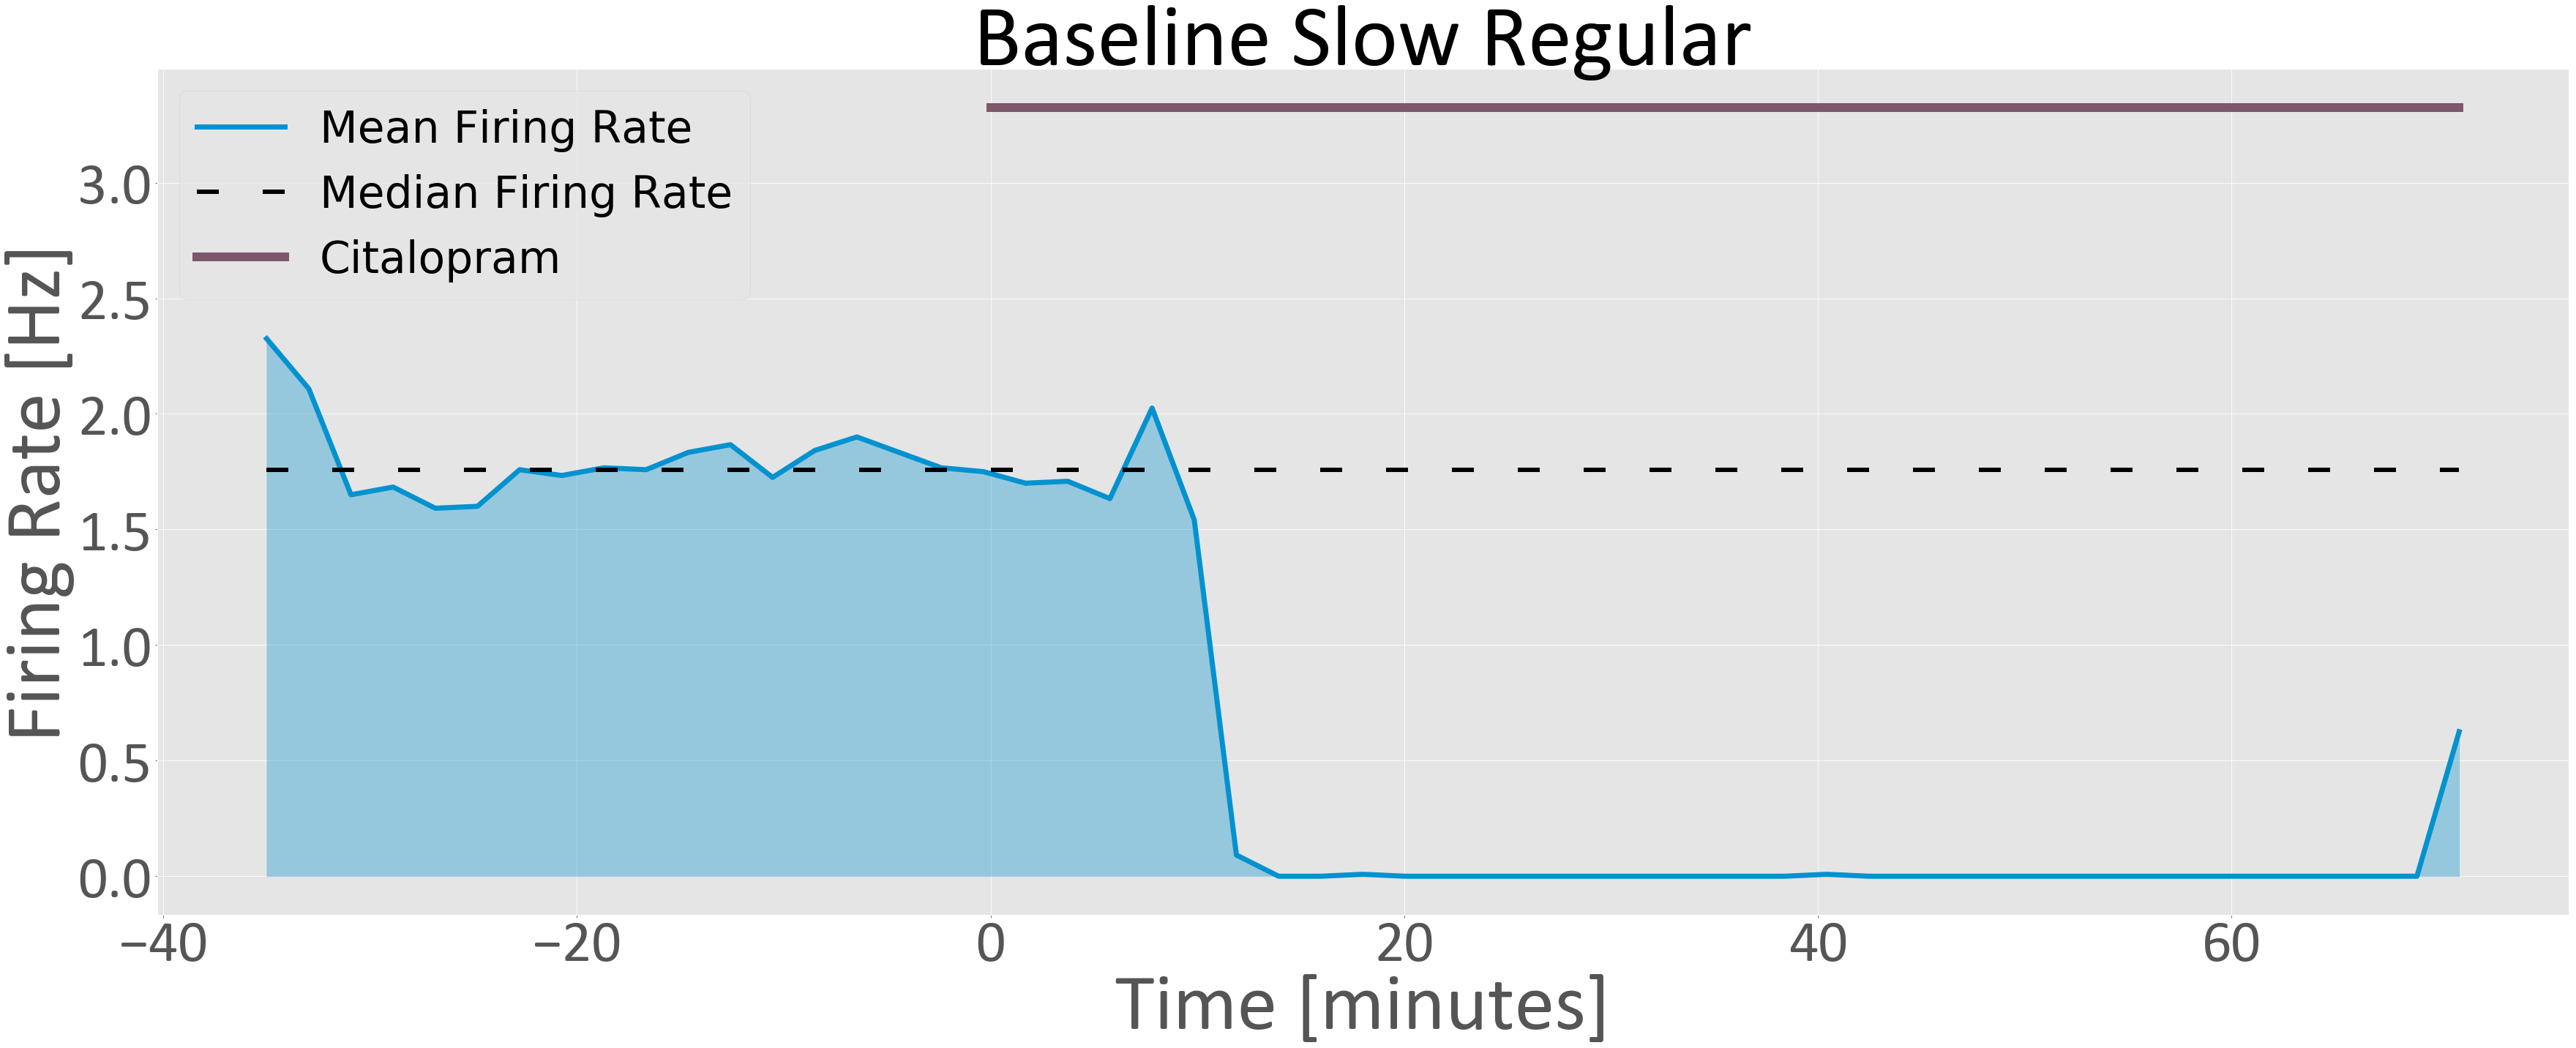

In [100]:
plot_cluster(dfs=[mean_firing_rates_ts], 
             color=color, 
             max_time=max_time, 
             experiment=experiment, 
             recording=recording, 
             medians=pd.DataFrame(mean_firing_rates_ts.iloc[:15, :].apply(np.nanmedian)), 
             n_conditions=n_conditions, labs=['Firing Rate', 'CV-ISI'], column=cluster)
